In [1]:
import importlib
import math
import json
import os
import sys
import pandas as pd
import numpy as np
from tqdm import tqdm
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from IPython.display import display
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler

In [2]:
current_dir = os.getcwd()
base_dir = os.path.dirname(current_dir)
data_dir = os.path.join(base_dir, 'data/processed')

In [3]:
df = pd.read_csv(os.path.join(data_dir, 'supervised_anomaly_detection_results.csv'))

In [4]:
df

,Timestamp,Batch ID,Temperature (°C),pH,Pressure (kPa),Quality Metric (%),Dissolved Oxygen (%),Conductivity (mS/cm),UV Absorbance,RNA Folding Efficiency (%),Nanopore RNA Integrity (Score),Enzyme Concentration (U/mL),Potential_Anomaly,pH_Lag_1,pH_Lag_2,pH_Rolling_Mean,pH_Rolling_Std,Quality_Metric_Rolling_Mean,Quality_Metric_Rolling_Std,Anomaly_Predicted
0,2024-12-08 09:30:00,Batch_001,37.849479,7.509330,102.265556,89.192131,56.715008,14.496277,1.364898,95.333207,7.857872,110.393969,0,7.194705,7.401403,7.352017,0.222473,87.292283,2.686790,0
1,2024-12-08 09:45:00,Batch_001,37.826280,7.477816,101.563845,85.563237,60.153157,14.763025,0.139943,95.998188,8.635882,109.628975,0,7.509330,7.194705,7.493573,0.022284,87.377684,2.566015,0
2,2024-12-08 10:00:00,Batch_001,37.261331,7.297432,100.774389,87.445622,61.257851,14.698342,1.221301,99.639942,8.946542,106.193801,0,7.477816,7.509330,7.387624,0.127550,86.504430,1.331047,0
3,2024-12-08 10:15:00,Batch_001,37.322777,7.431983,99.811039,90.737535,62.384145,15.357686,1.936305,90.418286,8.323373,110.235336,0,7.297432,7.477816,7.364707,0.095142,89.091579,2.327734,0
4,2024-12-08 10:30:00,Batch_001,37.764469,7.444782,100.146733,85.190505,61.477515,15.304527,0.343423,97.870172,9.764178,124.427149,0,7.431983,7.297432,7.438382,0.009051,87.964020,3.922342,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,2024-12-09 07:45:00,Batch_003,37.681209,7.515834,101.378554,90.561076,59.244882,14.434512,0.720013,93.046872,7.809654,122.071441,0,7.559943,7.440068,7.537888,0.031190,90.294945,0.376366,0
290,2024-12-09 08:00:00,Batch_003,38.399242,7.357286,101.116423,86.182746,58.981271,15.037926,0.816031,90.793619,8.184243,129.071439,0,7.515834,7.559943,7.436560,0.112110,88.371911,3.095947,0
291,2024-12-09 08:15:00,Batch_003,37.529792,7.348742,102.700948,85.639828,57.848483,13.891028,1.108147,93.570071,7.795571,102.805039,0,7.357286,7.515834,7.353014,0.006042,85.911287,0.383900,0
292,2024-12-09 08:30:00,Batch_003,36.711263,7.399176,101.509033,90.214193,63.947165,15.745305,1.949443,99.425983,9.618155,119.397999,0,7.348742,7.357286,7.373959,0.035662,87.927011,3.234564,0


In [5]:
df.columns

Index(['Timestamp', 'Batch ID', 'Temperature (°C)', 'pH', 'Pressure (kPa)',
       'Quality Metric (%)', 'Dissolved Oxygen (%)', 'Conductivity (mS/cm)',
       'UV Absorbance', 'RNA Folding Efficiency (%)',
       'Nanopore RNA Integrity (Score)', 'Enzyme Concentration (U/mL)',
       'Potential_Anomaly', 'pH_Lag_1', 'pH_Lag_2', 'pH_Rolling_Mean',
       'pH_Rolling_Std', 'Quality_Metric_Rolling_Mean',
       'Quality_Metric_Rolling_Std', 'Anomaly_Predicted'],
      dtype='object')

In [6]:
from sklearn.preprocessing import LabelEncoder

# Initialize the encoder
label_encoder = LabelEncoder()

# Fit and transform Batch_ID column
df["Batch_ID_encoded"] = label_encoder.fit_transform(df["Batch ID"])

# Drop the original column if necessary
df = df.drop(columns=["Batch ID"])

# Display unique mappings (optional)
print(dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))


{'Batch_001': np.int64(0), 'Batch_002': np.int64(1), 'Batch_003': np.int64(2)}


In [7]:
X = df[['Batch_ID_encoded', 'Temperature (°C)', 'pH', 'Pressure (kPa)',
       'Quality Metric (%)', 'Dissolved Oxygen (%)', 'Conductivity (mS/cm)',
       'UV Absorbance', 'RNA Folding Efficiency (%)',
       'Nanopore RNA Integrity (Score)', 'Enzyme Concentration (U/mL)',
       ]]



y = df['Anomaly_Predicted']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)

X_train shape: (235, 11)
y_train shape: (235,)


In [9]:
X_train

,Batch_ID_encoded,Temperature (°C),pH,Pressure (kPa),Quality Metric (%),Dissolved Oxygen (%),Conductivity (mS/cm),UV Absorbance,RNA Folding Efficiency (%),Nanopore RNA Integrity (Score),Enzyme Concentration (U/mL)
181,1,38.221851,7.614697,100.751192,92.059651,58.538174,14.694757,3.156848,93.732865,9.831771,101.222813
209,2,38.177684,7.459862,102.204923,89.017862,62.475355,14.484262,1.315574,93.990318,8.564662,126.371340
168,1,36.385383,7.356103,101.963787,87.274106,61.222179,14.525199,0.749522,97.956214,7.719771,124.829989
6,0,37.553917,7.393465,101.438484,90.478347,63.143834,15.024714,-0.449517,92.491427,8.044433,116.318925
224,2,37.570241,7.565282,101.429093,92.851881,60.447508,16.126749,0.524747,91.582526,7.594588,127.984317
...,...,...,...,...,...,...,...,...,...,...,...
188,1,37.493146,7.553408,102.006410,86.099048,59.350782,14.712606,1.111245,97.456407,8.137055,111.315593
71,0,37.682739,7.401162,100.566126,86.929544,59.164223,14.600732,-0.411716,99.259102,8.773653,127.185249
106,1,37.108474,6.566848,101.373971,64.835331,59.318107,15.595452,-0.339056,83.736663,5.746956,123.641816
270,2,37.792890,7.483807,100.536954,89.762811,60.829050,15.340882,2.093663,96.689596,8.800619,116.753599


In [10]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)  # For X_train
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)    # For X_test
y_train_tensor = torch.tensor(y_train.values.astype(int), dtype=torch.long)  # For y_train
y_test_tensor = torch.tensor(y_test.values.astype(int), dtype=torch.long)

torch.save(X_train_tensor, os.path.join(data_dir, 'X_train_tensor.pt'))
torch.save(X_test_tensor, os.path.join(data_dir, 'X_test_tensor.pt'))
torch.save(y_train_tensor, os.path.join(data_dir, 'y_train_tensor.pt'))
torch.save(y_test_tensor, os.path.join(data_dir, 'y_test_tensor.pt'))



In [11]:
class MLP(nn.Module):
  #initialising the model with parameters = Define the layers
    def __init__(
        self, input_dim, hidden_dim, output_dim, is_verbose=False
    ):
        '''
        :param input_dim: input dimension (total number of genes for example)
        :param hidden_dim: hidden dimension (some number)
        :param output_dim: output dimension 
        :param is_verbose: flag indicating whether to print
        '''
        super().__init__()
        #call the parent constructor class
        self.is_verbose = is_verbose

        self.fc_layer1 = nn.Linear(input_dim, hidden_dim)
        self.activation = nn.ReLU()
        self.fc_layer2 = nn.Linear(hidden_dim, output_dim)


#--> basically we defined all the puzle pieces above and now we are putting them
#in the correct order
    def forward(self, input: torch.Tensor):
        '''
        :param input: input tensor of shape (batch_size, input_dim)
        :return: return tensor of shape (batch_size, output_dim)
        '''
        x = self.fc_layer1(input)
        x = self.activation(x)
        x = self.fc_layer2(x)
        return x

In [12]:
# Shape
input_size = X_train.shape[1]  # Number of features = how many genes we have
output_size = len(set(y_train))  # Number of classes, for classification = how many cell types we have
print(f"number of features measured are {input_size} and the number of classes are {output_size}, indicating if anomally detected or not")
#Hyperparameters
num_epochs = 10
batch_size = 100
learning_rate = 0.001
hidden_size = 64

number of features measured are 11 and the number of classes are 2, indicating if anomally detected or not


In [13]:
model = MLP(input_size, hidden_size, output_size, is_verbose=True)

In [14]:
# Define the loss function and the optimizer
loss_fun = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [15]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

In [16]:
train_loader = DataLoader(train_dataset, batch_size=50, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

In [17]:
train_features, train_labels = next(iter(train_loader))
# Sanity check for shape of matrix
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([50, 11])
Labels batch shape: torch.Size([50])


In [18]:
print(model)

MLP(
  (fc_layer1): Linear(in_features=11, out_features=64, bias=True)
  (activation): ReLU()
  (fc_layer2): Linear(in_features=64, out_features=2, bias=True)
)


In [19]:
from sklearn.metrics import accuracy_score, f1_score

In [20]:
def test_model(test_loader):
  seed = 42
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True

  accuracies = []
  f1_scores = []
  f1_scores_macro = []
  f1_scores_micro = []

  errors = []
  batch_losses = []
  eval_batch_losses = []  # List to store batch losses during evaluation
  all_labels = []
  all_predictions = []

  error = 0
  correct = 0
  total = 0

  model.eval()

  with torch.no_grad():
    for batch_features, batch_labels in test_loader:
        # Compute output and loss function
        outputs = model(batch_features)
        loss = loss_fun(outputs, batch_labels)

        eval_batch_losses.append(loss.item())  # Store the batch loss
        print(f"Batch Loss: {loss.item()}")

        # Get predictions
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(batch_labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

        error += loss.item()  # Accumulate the loss value
        total += batch_labels.size(0)
        correct += (predicted == batch_labels).sum().item()
        accuracy = 100 * correct / total
        accuracies.append(accuracy)

    average_loss = error / len(test_loader)  # Average loss per batch
    errors.append(average_loss)  # Store the average loss
    accuracy = 100 * correct / total  # Calculate accuracy
    accuracies.append(accuracy)  # Store the accuracy
    eval_f1_score = f1_score(all_labels, all_predictions, average='weighted')  # Calculate F1 score
    f1_scores.append(eval_f1_score)

  print(f' Loss: {average_loss}, F1 Score: {eval_f1_score}, Accuracy: {accuracy}%')
  print("Finished Testing.")
  print("======================================================================")

  return model, accuracies, f1_scores

In [21]:
def train_model(train_loader, num_epochs):
  seed = 42
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True

  accuracies = []
  #accuracies_val = []
  f1_scores = []
  f1_scores_macro = []
  f1_scores_micro = []
  epochs = num_epochs
  errors = []
  batch_losses = []
  total = 0
  correct = 0
  error = 0

  for epoch in range(epochs):
    print("\nStarting training ")
    print("======================================================================")
    print(f"Epoch {epoch + 1}")
    error = 0
    model.train()  # Set the model to training mode

    for batch_features, batch_labels in train_loader:

        # Set gradients to zero
        #Zeroing out the gradients after each epoch ensures a clean slate for the next epoch.
        #Helps prevent getting stuck in local minim
        optimizer.zero_grad()

        # Compute output and loss function
        outputs = model(batch_features)
        loss = loss_fun(outputs, batch_labels)

        # Apply backpropagation to output tensor, which will
        # automatically compute gradients of model parameters
        loss.backward()

        # Update model parameters based on computed gradients
        optimizer.step()
        batch_losses.append(loss.item())  # Store the batch loss
        print(f'Epoch {epoch + 1}, Loss: {loss.item()}')

    # Calculate accuracy and F1 score for this batch
        _, predicted = torch.max(outputs.data, 1)
        total = batch_labels.size(0)
        correct = (predicted == batch_labels).sum().item()
        accuracy = 100 * correct / total
        accuracies.append(accuracy)
        f1_sco = f1_score(batch_labels.cpu(), predicted.cpu(), average='weighted')
        f1_scores.append(f1_sco)
        f1_sco_macro = f1_score(batch_labels.cpu(), predicted.cpu(), average='macro')
        f1_scores_macro.append(f1_sco_macro)
        f1_sco_micro = f1_score(batch_labels.cpu(), predicted.cpu(), average='micro')
        f1_scores_micro.append(f1_sco_micro)
        

        print(f'Batch Accuracy: {accuracy:.2f}%, Batch F1 Score: {f1_sco:.4f}')

    model.train()
    
    average_loss = sum(batch_losses) / len(batch_losses)  # Average loss per batch
    errors.append(average_loss)  # Store the average loss

    print(f'Epoch {epoch + 1}/{epochs}, Average Loss: {average_loss}')
    print("Finished training.")
    print("======================================================================")

  # Plot training loss
  plt.plot(range(epochs), errors, marker='o', linestyle='--', color='blue')
  plt.xlabel('Epoch')
  plt.ylabel('Training Loss')
  plt.title('Training Loss Over Epochs')
  plt.show()



  # Plotting the loss per batch
  plt.figure(figsize=(20, 6))
  plt.plot(batch_losses, marker='o', linestyle='-', color='black')
  plt.title('Training Loss per Batch')
  plt.xlabel('Batch Number')
  plt.ylabel('Loss')
  for x in range(30, len(batch_losses), 30):
      plt.axvline(x=x, color='red', linestyle='--')

  plt.grid(True)
  plt.show()
  f1_scores_100 = [num * 100 for num in f1_scores]
  print("Accuracies per batch are = ", accuracies)
  print("F1 scores per batch are = ", f1_scores)

# Plot accuracy and F1 score over batches
  plt.figure()
  plt.plot(range(len(accuracies)), accuracies, marker='o', linestyle='--', color='green', label='Accuracy')
  plt.plot(range(len(f1_scores_100)), f1_scores_100, marker='x', linestyle='-', color='red', label='F1 Score')
  plt.xlabel('Batch')
  plt.ylabel('Score')
  plt.title('Batch Accuracy and F1 Score(x100)')
  plt.legend()
  plt.show()

  print("F1 scores macro per batch are = ", f1_scores_macro)
  print("F1 scores micro per batch are = ", f1_scores_micro)

  plt.figure()
  plt.plot(range(len(f1_scores_macro)), f1_scores_macro, marker='o', linestyle='--', color='green', label='F1 Score Macro')
  plt.plot(range(len(f1_scores_micro)), f1_scores_micro, marker='x', linestyle='-', color='red', label='F1 Score Micro')
  plt.plot(range(len(f1_scores)), f1_scores, marker='x', linestyle='-', color='blue', label='F1 Score Weighted')
  # plt.plot(range(len(f1_scores_samples)), f1_scores_samples, marker='x', linestyle='-', color='orange', label='F1 Score Samples')
  plt.xlabel('Batch')
  plt.ylabel('Score')
  plt.title('Different F1 scores')
  plt.legend()



  # Print model parameters
  print('bias for first layer =', model.fc_layer1.bias.data)
  print('bias shape is =', model.fc_layer1.bias.data.shape)
  print('weight for first layer =', model.fc_layer1.weight.data)
  print('weight shape is =', model.fc_layer1.weight.data.shape)
  print("========================================================================")
  print("bias for second layer =", model.fc_layer2.bias.data)
  print('bias shape is =', model.fc_layer2.bias.data.shape)
  print("weight for second layer=", model.fc_layer2.weight.data)
  print('weight shape is =', model.fc_layer2.weight.data.shape)
  return model, errors, accuracies, f1_scores_micro


Starting training 
Epoch 1
Epoch 1, Loss: 11.044342041015625
Batch Accuracy: 4.00%, Batch F1 Score: 0.0031
Epoch 1, Loss: 3.235032320022583
Batch Accuracy: 96.00%, Batch F1 Score: 0.9404
Epoch 1, Loss: 1.6050653457641602
Batch Accuracy: 98.00%, Batch F1 Score: 0.9701
Epoch 1, Loss: 4.422964572906494
Batch Accuracy: 94.00%, Batch F1 Score: 0.9109
Epoch 1, Loss: 0.0
Batch Accuracy: 100.00%, Batch F1 Score: 1.0000
Epoch 1/10, Average Loss: 4.061480855941772
Finished training.

Starting training 
Epoch 2
Epoch 2, Loss: 1.4582515954971313
Batch Accuracy: 98.00%, Batch F1 Score: 0.9701
Epoch 2, Loss: 2.7855756282806396
Batch Accuracy: 96.00%, Batch F1 Score: 0.9404
Epoch 2, Loss: 5.155266284942627
Batch Accuracy: 92.00%, Batch F1 Score: 0.8817
Epoch 2, Loss: 0.0
Batch Accuracy: 100.00%, Batch F1 Score: 1.0000
Epoch 2, Loss: 1.5308407545089722
Batch Accuracy: 97.14%, Batch F1 Score: 0.9573
Epoch 2/10, Average Loss: 3.1237338542938233
Finished training.

Starting training 
Epoch 3
Epoch 3, Lo

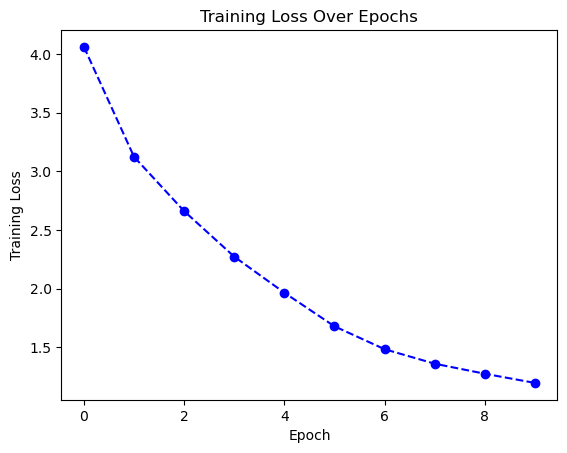

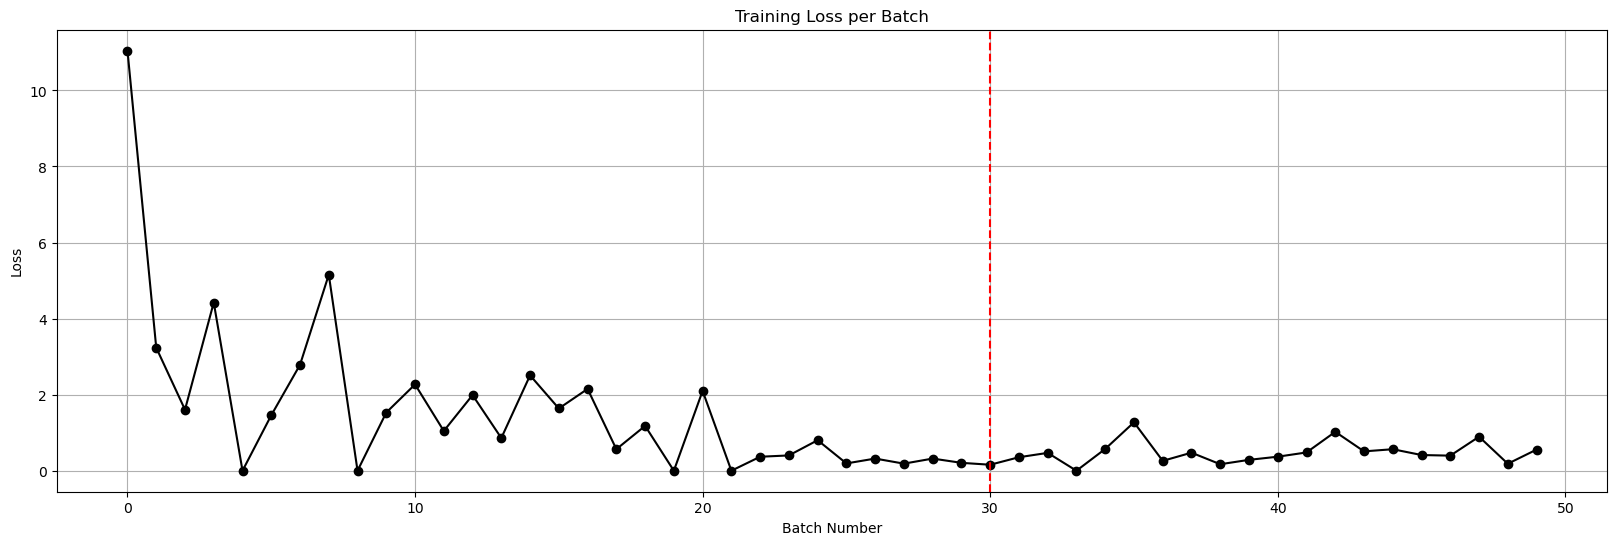

Accuracies per batch are =  [4.0, 96.0, 98.0, 94.0, 100.0, 98.0, 96.0, 92.0, 100.0, 97.14285714285714, 96.0, 98.0, 96.0, 98.0, 94.28571428571429, 96.0, 94.0, 98.0, 96.0, 100.0, 92.0, 100.0, 98.0, 98.0, 94.28571428571429, 98.0, 96.0, 98.0, 96.0, 94.28571428571429, 96.0, 94.0, 78.0, 100.0, 97.14285714285714, 94.0, 98.0, 96.0, 98.0, 97.14285714285714, 94.0, 80.0, 96.0, 98.0, 97.14285714285714, 98.0, 98.0, 94.0, 98.0, 94.28571428571429]
F1 scores per batch are =  [np.float64(0.003076923076923077), np.float64(0.9404081632653061), np.float64(0.9701010101010101), np.float64(0.9109278350515464), np.float64(1.0), np.float64(0.9701010101010101), np.float64(0.9404081632653061), np.float64(0.8816666666666667), np.float64(1.0), np.float64(0.9573498964803312), np.float64(0.9404081632653061), np.float64(0.9701010101010101), np.float64(0.9404081632653061), np.float64(0.9701010101010101), np.float64(0.9151260504201681), np.float64(0.9404081632653061), np.float64(0.9109278350515464), np.float64(0.970101

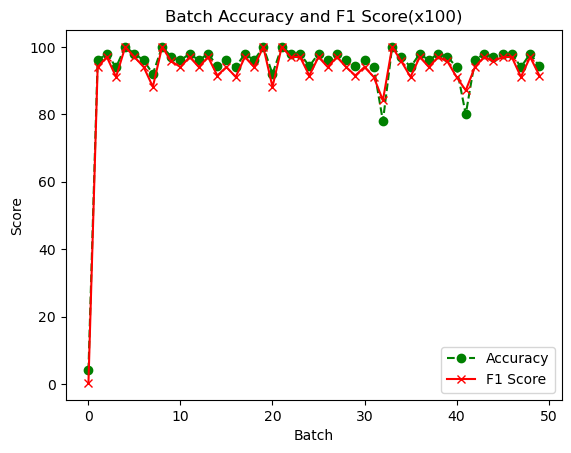

F1 scores macro per batch are =  [np.float64(0.038461538461538464), np.float64(0.4897959183673469), np.float64(0.494949494949495), np.float64(0.4845360824742268), np.float64(1.0), np.float64(0.494949494949495), np.float64(0.4897959183673469), np.float64(0.4791666666666667), np.float64(1.0), np.float64(0.4927536231884058), np.float64(0.4897959183673469), np.float64(0.494949494949495), np.float64(0.4897959183673469), np.float64(0.494949494949495), np.float64(0.4852941176470588), np.float64(0.4897959183673469), np.float64(0.4845360824742268), np.float64(0.494949494949495), np.float64(0.4897959183673469), np.float64(1.0), np.float64(0.4791666666666667), np.float64(1.0), np.float64(0.494949494949495), np.float64(0.494949494949495), np.float64(0.4852941176470588), np.float64(0.494949494949495), np.float64(0.4897959183673469), np.float64(0.494949494949495), np.float64(0.4897959183673469), np.float64(0.4852941176470588), np.float64(0.4897959183673469), np.float64(0.4845360824742268), np.float6

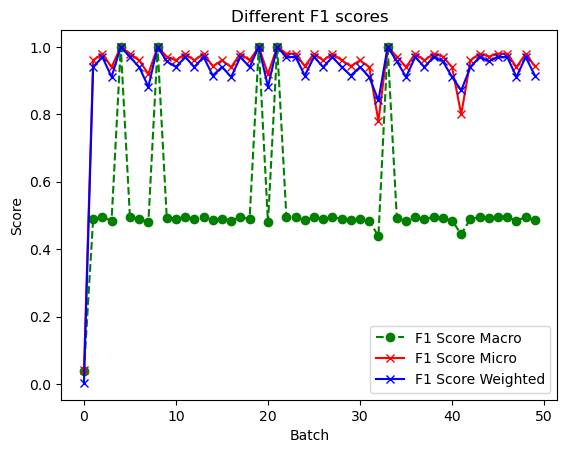

In [22]:
model1, errors1, accuracies1, f1_scores1 = train_model(train_loader, num_epochs)

In [23]:
torch.save(model1.state_dict(), 'model.pth')

# Model Explainability

In [24]:
def predict_proba(data):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        data_tensor = torch.tensor(data, dtype=torch.float32)  # Convert data to tensor
        logits = model(data_tensor)  # Forward pass
        probabilities = F.softmax(logits, dim=1)  # Convert logits to probabilities
    return probabilities.numpy()  # Convert to NumPy array for SHAP

In [25]:
import shap



# Create SHAP explainer
explainer = shap.KernelExplainer(predict_proba, X_train)

shap_values = explainer.shap_values(X_train)  # Compute SHAP values


Using 235 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/235 [00:00<?, ?it/s]

In [26]:
len(shap_values)

235

In [27]:
shap_values

array([[[-1.85041741e-05,  1.85039900e-05],
        [ 9.65292660e-04, -9.65290556e-04],
        [ 4.69442705e-04, -4.69440413e-04],
        ...,
        [-2.24503738e-03,  2.24503950e-03],
        [ 9.58890672e-03, -9.58890420e-03],
        [-4.03805314e-02,  4.03805333e-02]],

       [[ 1.41328312e-04, -1.41322545e-04],
        [ 4.04739944e-04, -4.04734037e-04],
        [ 7.58053667e-05, -7.57990603e-05],
        ...,
        [-6.39982262e-04,  6.39988808e-04],
        [-5.01938597e-04,  5.01945238e-04],
        [ 2.17656751e-02, -2.17656689e-02]],

       [[-3.75023503e-06,  3.75225284e-06],
        [-5.81951146e-04,  5.81954271e-04],
        [-1.12486559e-05,  1.12526344e-05],
        ...,
        [ 4.64873769e-03, -4.64873432e-03],
        [-3.06643808e-03,  3.06644169e-03],
        [ 1.66622690e-02, -1.66622657e-02]],

       ...,

       [[-4.67993691e-06,  4.67628281e-06],
        [-2.63544925e-04,  2.63543580e-04],
        [-7.28410523e-04,  7.28408197e-04],
        ...,
     

In [28]:
print("SHAP Values Shape (Corrected):", shap_values.shape)  # Should be (235, 8, 2)
shap_values_class_1 = shap_values[:, :, 0]  # Extract SHAP values for class 1
print("SHAP Values Shape (Class 1):", shap_values_class_1.shape)  # Should be (235, 8)
shap_values_class_2 = shap_values[:, :, 1]  # Extract SHAP values for class 2
print("X_train Shape:", X_train.shape)  # Should be (235, 8)


SHAP Values Shape (Corrected): (235, 11, 2)
SHAP Values Shape (Class 1): (235, 11)
X_train Shape: (235, 11)


In [ ]:
shap_values_class_1

In [31]:
feature_names = X_train.columns

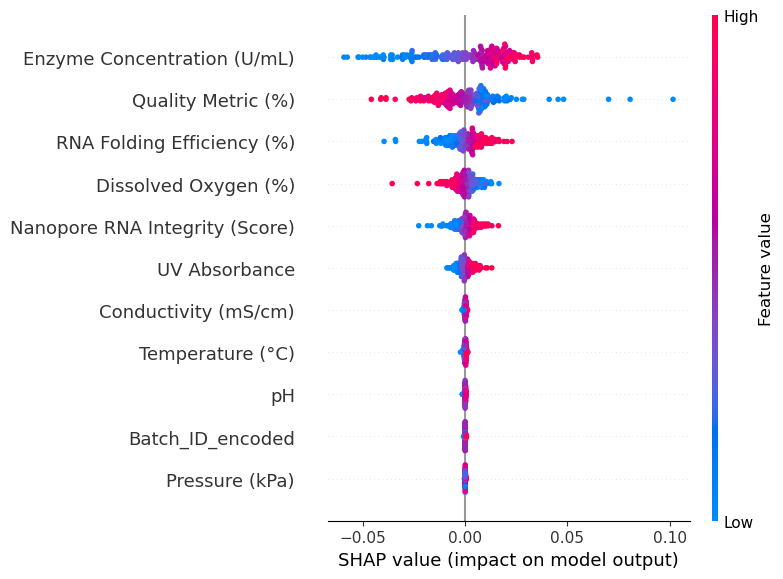

In [32]:
shap.summary_plot(shap_values_class_1, X_train, feature_names=feature_names)




Key Takeaways:

- The features are ranked by their overall impact on the model’s predictions.
The most important feature appears at the top (pH_Rolling_Std in this case), and the least important feature is at the bottom (pH).

- X-Axis: The SHAP value indicates the magnitude and direction of a feature’s contribution to a model’s prediction

- Color Gradient: Dots are colored based on the feature value